In [1]:
%cd /data/soyeonhong/nlq/nlq_lightning
%load_ext autoreload
%autoreload 2

/data/soyeonhong/nlq/nlq_lightning


In [2]:
from pathlib import Path
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
from torch import nn

from IPython.display import display
from PIL import Image
import decord
from einops import rearrange
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.patches as patches

np.set_printoptions(suppress=True)

from model.ours.dataset import JointDataModule
from model.ours.lightning_module import LightningModule

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
p_scene = Path('/data/soyeonhong/nlq/nlq_lightning/data/scene')
annotations = json.loads(Path('/data/soyeonhong/nlq/nlq_lightning/data/unified/annotations.NLQ_train.json').read_text())
clip_list = [ann['video_id'] for ann in annotations]
clip_list = list(set(clip_list))

In [19]:
num_scenes = []
scene_duration = []
for clip in clip_list:
    scene_data = torch.load(p_scene / f'{clip}.pt')
    for scene in scene_data:
        start, end = scene[0], scene[1]
        duration = (end - start) * 0.53
        scene_duration.append(duration)
    num_scenes.append(scene_data.shape[0])

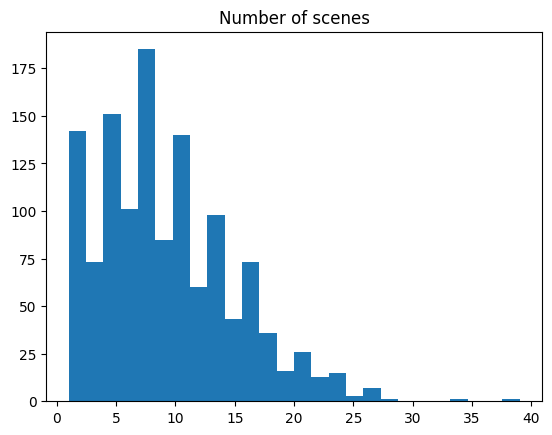

In [20]:
# plot num scenes
plt.hist(num_scenes, bins='auto')
plt.title('Number of scenes')
plt.show()

In [21]:
# max scenes
print(f"max: {max(num_scenes)}")
print(f"min: {min(num_scenes)}")

print(f"mean: {np.mean(num_scenes)}")
print(f"std: {np.std(num_scenes)}")
print(f"median: {np.median(num_scenes)}")
print(f"75th percentile: {np.percentile(num_scenes, 75)}")
print(f"bincount: {np.bincount(num_scenes)}")

max: 39
min: 1
mean: 9.209448818897638
std: 5.72123318394018
median: 8.0
75th percentile: 13.0
bincount: [  0  75  67  73  80  71 101  93  92  85  75  65  60  43  55  43  41  32
  36  16  17   9  13  10   5   3   6   1   1   0   0   0   0   0   1   0
   0   0   0   1]


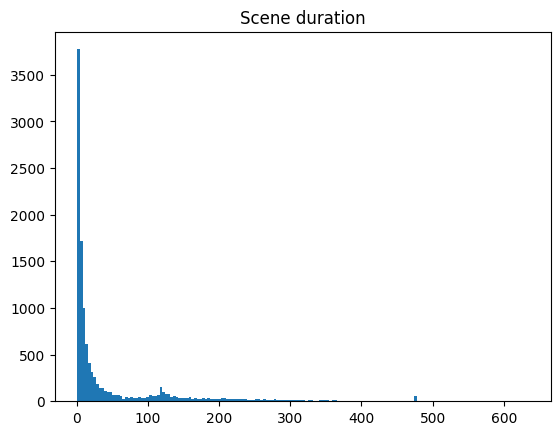

In [22]:
# plot scene duration
plt.hist(scene_duration, bins='auto')
plt.title('Scene duration')
plt.show()


In [23]:
print(f"max: {max(scene_duration)}")
print(f"min: {min(scene_duration)}")

print(f"mean: {np.mean(scene_duration)}")
print(f"std: {np.std(scene_duration)}")
print(f"median: {np.median(scene_duration)}")
print(f"75th percentile: {np.percentile(scene_duration, 75)}")
print(f"bincount: {np.bincount(scene_duration)}")

max: 634.4099731445312
min: 1.059999942779541
mean: 50.569820404052734
std: 88.043701171875
median: 10.069999694824219
75th percentile: 46.1099967956543
bincount: [   0  933 1134  896  810  625  513  404  171  350  311  227  217  206
  162  143  136   57  116  101   90   80  103   75   69   81   41   69
   59   50   45   37   40   50   40   19   39   36   39   32   34   31
   33   24   11   32   27   34   22   19   17   21   22   11   14   18
   21   19   18   16   18    7   19   11   12   11    6    5   14   12
    6   11   14    5   11   13    9   11   16    2   10   12    9   15
    7   10    7   16    9   13   11   12   11   11    8   11   15    2
   12   11   16   16   17   24   12   15    8   10   19   17   15   18
   19   18   10   12   37   48   45   42   32   29   21   14   27   23
   23   14   21   19   19   15    6   13   18   13   12   12   23   16
   20    8    6   12    9    8    8   13   13    8    4   11   14   10
   10   13    9   11   11    5   15   10    7   10    6 

In [3]:
GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='../config', job_name='asdasdasdasdasd')
config = hydra.compose(config_name='base', overrides=[f'total_bsz=1'])

/tmp/ipykernel_3710364/481420503.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../config', job_name='asdasdasdasdasd')


In [4]:
data = JointDataModule(config)
data.setup()
val = data.val_dataset
annotations = val.datasets[0].annotations

NLQ_train set: 13847
NLQ_val set: 4552
#train: 13847
#val: 4552
#test: 4552


/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
def interp_t(tensor, T_target, mode='nearest'):
    # tensor: [T_source, D]
    D, dtype = tensor.shape[-1], tensor.dtype
    return F.interpolate(tensor[None, None].float(), size=(T_target, D), mode=mode).squeeze([0, 1]).to(dtype=dtype)

def plot_similarity(sim, clip_uid, query, time_interval=0.5, figsize=(9, 7), cmap='viridis', title=None, scene=None):

    plt.figure(figsize=figsize)
    plt.imshow(sim, aspect='auto', cmap=cmap)
    plt.colorbar(label='Similarity')

    tick_positions = np.arange(0, sim.shape[0], 50)
    tick_labels = (tick_positions * time_interval).astype(int)

    plt.xticks(tick_positions, labels=tick_labels, rotation=90)
    plt.yticks(tick_positions, labels=tick_labels)

    plt.xlabel('Time (s)')
    plt.title(f'{title}\n{clip_uid}\n{query}', fontsize=9)
    
    if scene is not None:
        # Add rectangles based on ranges
        ax = plt.gca()
        for start, end in scene:
            # Calculate the center of the range
            center = (start + end) / 2
            size = (end - start)  # Box size matches range length
            
            # Calculate top-left corner for the square
            top_left = center - size / 2
            
            # Draw square
            rect = patches.Rectangle(
                (top_left, top_left),  # Bottom-left corner
                size,                  # Width
                size,                  # Height
                linewidth=3,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)
    
    plt.show()

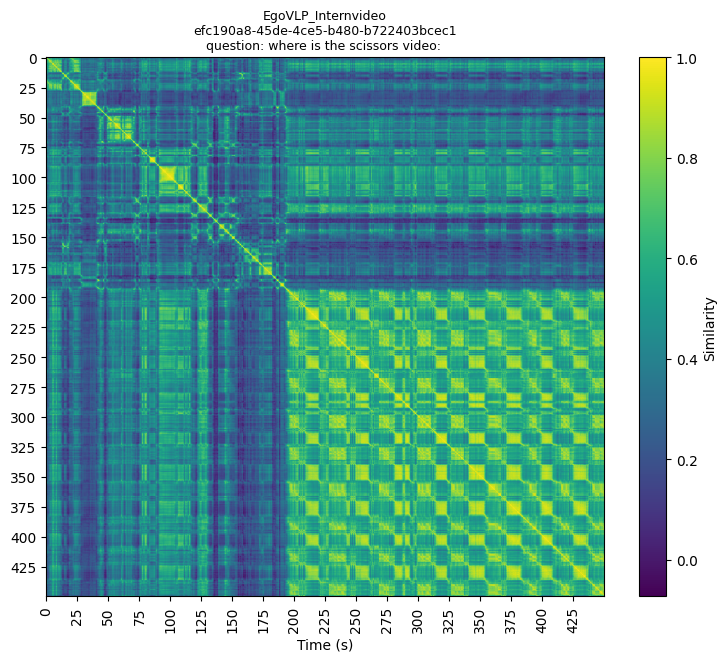

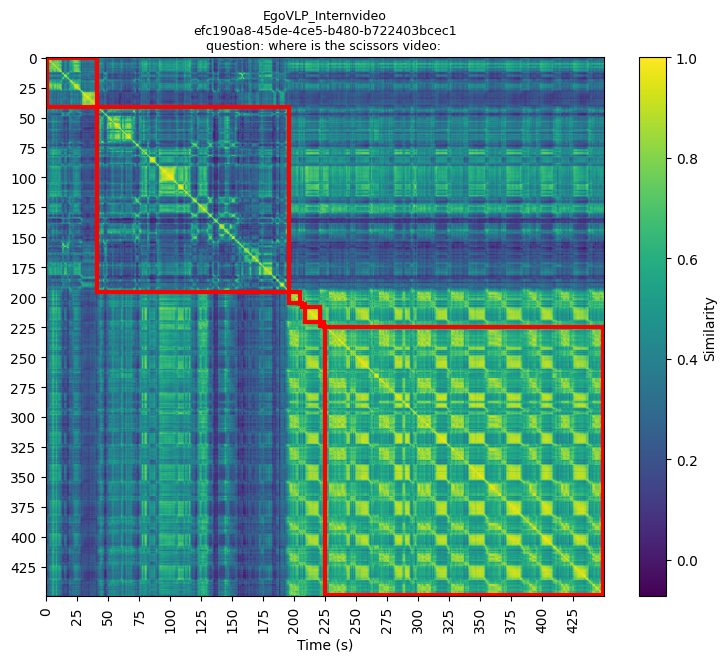

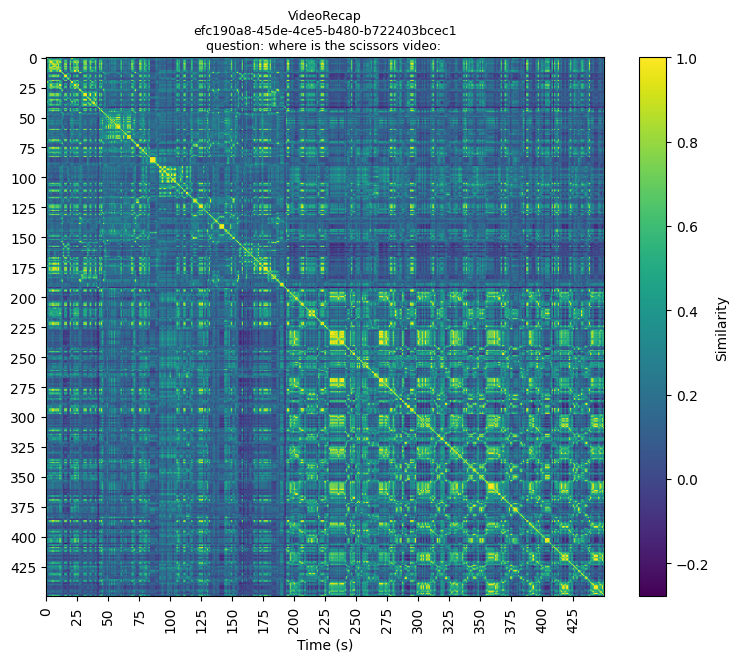

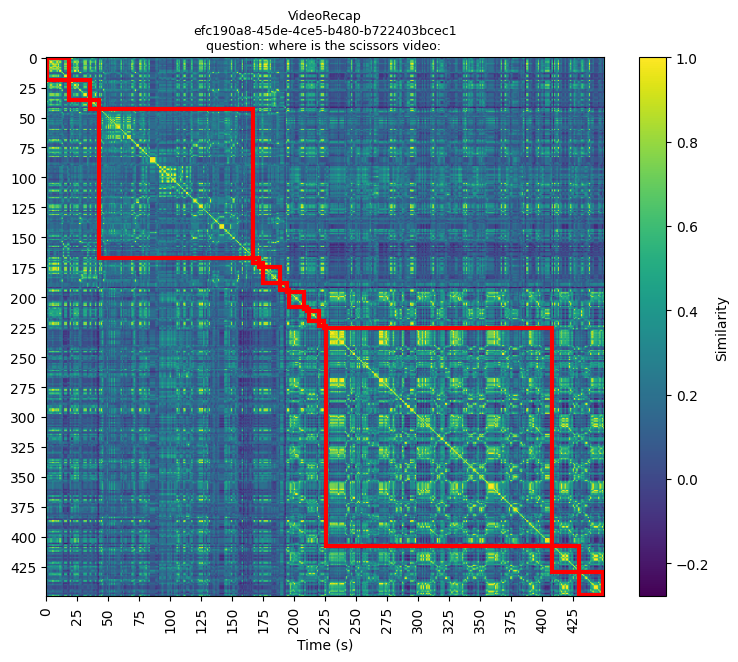

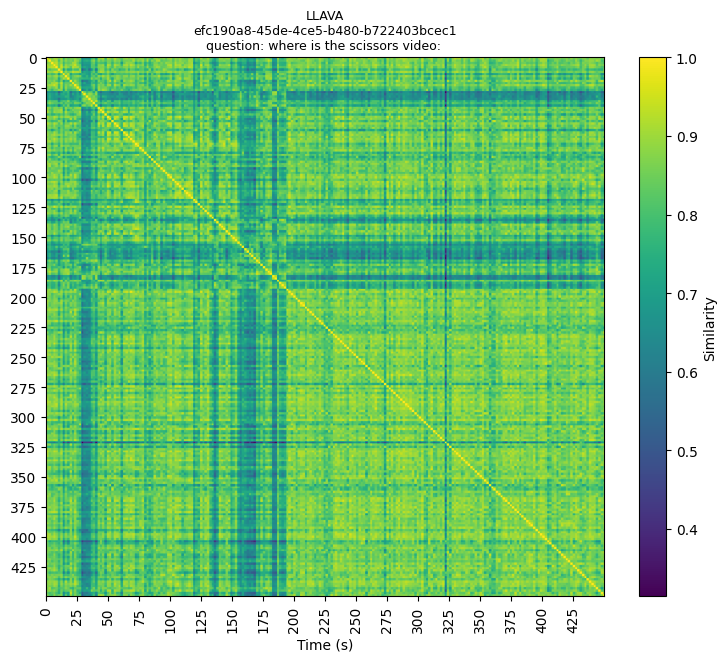

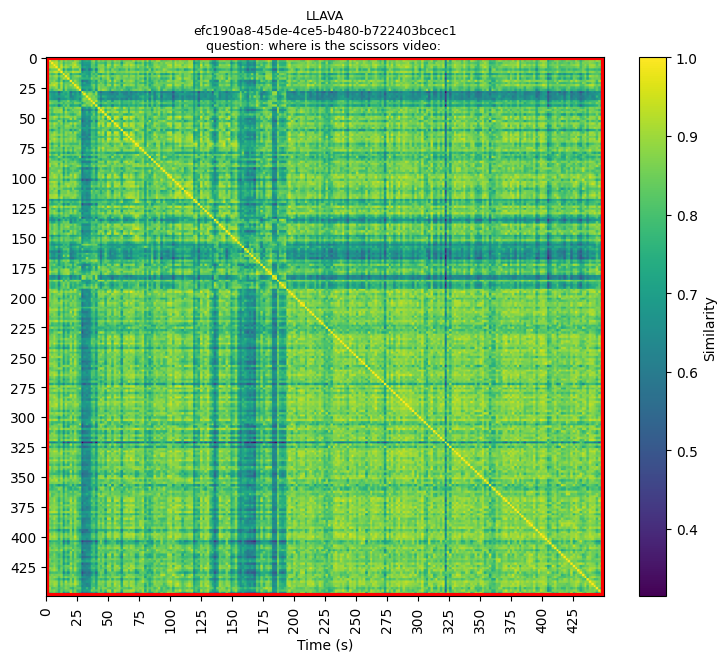

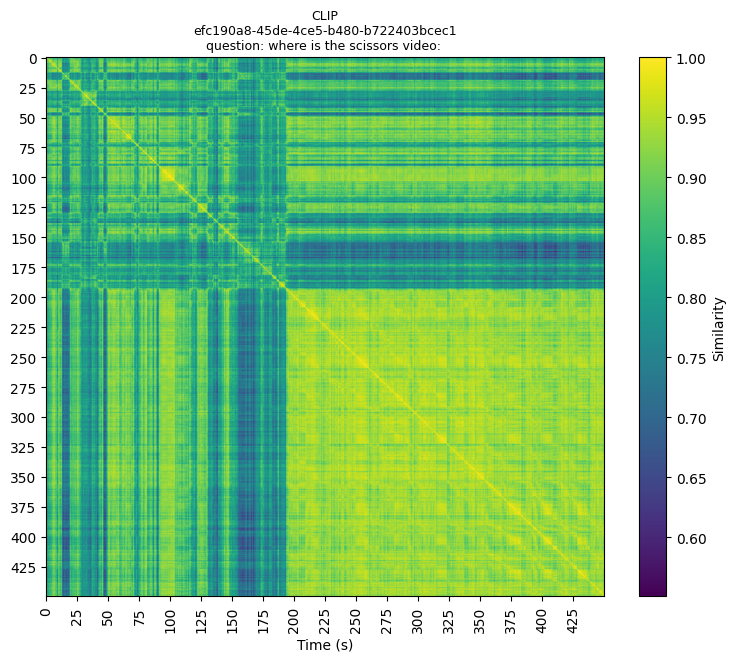

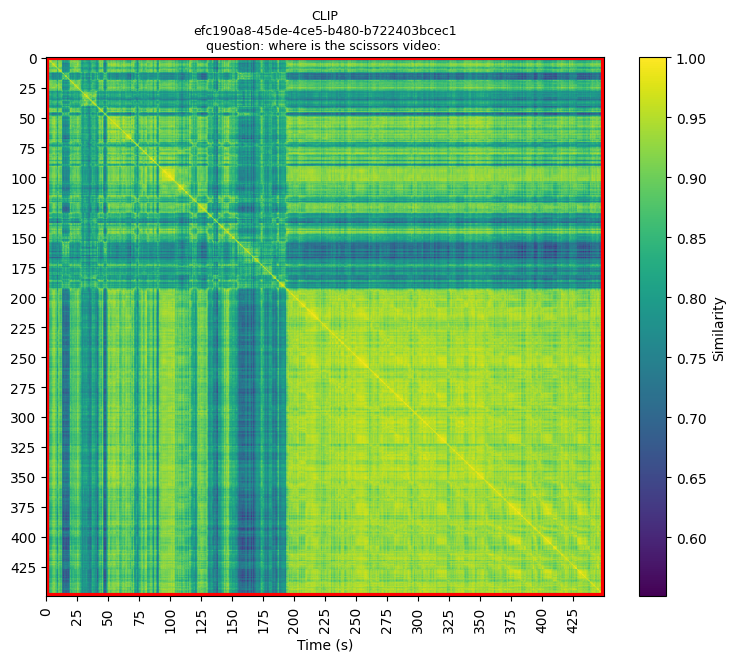

In [87]:
idx = random.randint(0, len(annotations))

sample = val[idx]
clip_uid = sample['video_id']
query = sample['question']

v_feat = sample['v_feat']
v_mask = torch.ones(len(v_feat)).bool()
question_tok = val.tokenizer(query, padding=True, return_tensors='pt', add_special_tokens=False)
q_token = question_tok.input_ids
q_mask = question_tok.attention_mask.bool()
v_len = sample['v_len']

# p_clip_feat = Path('/data/soyeonhong/nlq/ego4d/CLIP/clip_ego4d_feature')
p_clip_feat = Path('/data/soyeonhong/nlq/ego4d/CLIP/__clip_ego4d_feature')
p_egovlp_vrecap = Path('/data/soyeonhong/nlq/nlq_lightning/data/egovlp/videorecap')
p_egovlp_llava = Path('/data/soyeonhong/nlq/nlq_lightning/data/egovlp/llava')

p_clip_scene = Path('/data/soyeonhong/nlq/nlq_lightning/data/scene/clip')
p_vrecap_scene = Path('/data/soyeonhong/nlq/nlq_lightning/data/scene/egovlp/videorecap')
p_llava_scene = Path('/data/soyeonhong/nlq/nlq_lightning/data/scene/egovlp/llava')
p_video_scene = Path('/data/soyeonhong/nlq/nlq_lightning/data/scene/egovlp_internvideo')


clip_feat = torch.load(p_clip_feat / f'{clip_uid}.pth').to(torch.float32)
vrecap_feat = torch.load(p_egovlp_vrecap / f'{clip_uid}.pt')
llava_feat = torch.load(p_egovlp_llava / f'{clip_uid}.pt')

clip_scene = torch.load(p_clip_scene / f'{clip_uid}.pt')
vrecap_scene = torch.load(p_vrecap_scene / f'{clip_uid}.pt')
llava_scene = torch.load(p_llava_scene / f'{clip_uid}.pt')
video_scene = torch.load(p_video_scene / f'{clip_uid}.pt')

clip_feat = interp_t(clip_feat, v_len).unsqueeze(0)
vrecap_feat = interp_t(vrecap_feat, v_len).unsqueeze(0)
llava_feat = interp_t(llava_feat, v_len).unsqueeze(0)

v_feat = v_feat.unsqueeze(0)
v_feat_norm = v_feat / (v_feat.norm(dim=2, keepdim=True) + 1e-8)
tsm_v_feat = torch.bmm(v_feat_norm, v_feat_norm.transpose(1, 2))

clip_feat_norm = clip_feat / (clip_feat.norm(dim=2, keepdim=True) + 1e-8)
tsm_clip_feat = torch.bmm(clip_feat_norm, clip_feat_norm.transpose(1, 2))

vrecap_feat_norm = vrecap_feat / (vrecap_feat.norm(dim=2, keepdim=True) + 1e-8)
tsm_vrecap = torch.bmm(vrecap_feat_norm, vrecap_feat_norm.transpose(1, 2))

llava_feat_norm = llava_feat / (llava_feat.norm(dim=2, keepdim=True) + 1e-8)
tsm_llava = torch.bmm(llava_feat_norm, llava_feat_norm.transpose(1, 2))

plot_similarity(tsm_v_feat.squeeze().cpu().numpy(), clip_uid, query, title='EgoVLP_Internvideo')
plot_similarity(tsm_v_feat.squeeze().cpu().numpy(), clip_uid, query, title='EgoVLP_Internvideo', scene = video_scene)
plot_similarity(tsm_vrecap.squeeze().cpu().numpy(), clip_uid, query, title='VideoRecap')
plot_similarity(tsm_vrecap.squeeze().cpu().numpy(), clip_uid, query, title='VideoRecap', scene=vrecap_scene)
plot_similarity(tsm_llava.squeeze().cpu().numpy(), clip_uid, query, title='LLAVA')
plot_similarity(tsm_llava.squeeze().cpu().numpy(), clip_uid, query, title='LLAVA', scene=llava_scene)
plot_similarity(tsm_clip_feat.squeeze().cpu().numpy(), clip_uid, query, title='CLIP')
plot_similarity(tsm_clip_feat.squeeze().cpu().numpy(), clip_uid, query, title='CLIP', scene=clip_scene)

In [8]:
def compute_IoU(pred, gt):
        """Compute the IoU given predicted and ground truth windows."""
        assert isinstance(pred, list) and isinstance(gt, list)
        if len(pred) == 0:  # FIXME: I don't know why, maybe coincidence, that the PtTransformerRegHead produces all 0 offsets at the start of training
            return [0]
        pred_is_list = isinstance(pred[0], list)
        gt_is_list = isinstance(gt[0], list)
        if not pred_is_list:
            pred = [pred]
        if not gt_is_list:
            gt = [gt]
        pred, gt = np.array(pred), np.array(gt)
        inter_left = np.maximum(pred[:, 0, None], gt[None, :, 0])
        inter_right = np.minimum(pred[:, 1, None], gt[None, :, 1])
        inter = np.maximum(0.0, inter_right - inter_left)
        union_left = np.minimum(pred[:, 0, None], gt[None, :, 0])
        union_right = np.maximum(pred[:, 1, None], gt[None, :, 1])
        union = np.maximum(0.0, union_right - union_left)
        overlap = 1.0 * inter / union
        if not gt_is_list:
            overlap = overlap[:, 0]
        if not pred_is_list:
            overlap = overlap[0]
        return overlap

In [29]:
import h5py
video_features = h5py.File('/data/soyeonhong/nlq/nlq_lightning/data/unified/egovlp_internvideo.hdf5', 'r')
def _get_video_feature(video_id, video_features = video_features):
    max_v_len = 900
    video_feature = torch.from_numpy(video_features[video_id][:])
    v_len = video_feature.shape[0]
    sample_ratio = 1.0
    if v_len > max_v_len:
        sample_idx = torch.linspace(0, v_len-1, max_v_len).long()
        video_feature = video_feature[sample_idx]
        sample_ratio = max_v_len / v_len
        v_len = max_v_len
    return video_feature, v_len, sample_ratio

In [51]:
mask_size = 5

count = 0
count_under_10 = 0
count_up_10 = 0
iou_03 = 0
iou_05 = 0
p_scene = Path(f'/data/soyeonhong/nlq/nlq_lightning/data/scene/egovlp_internvideo/mask_{mask_size}')
annotations = json.loads(Path('/data/soyeonhong/nlq/nlq_lightning/data/unified/annotations.NLQ_val.json').read_text())
clip_list = [ann['video_id'] for ann in annotations]
clip_list = list(set(clip_list))

for ann in annotations:
    clip_uid = ann['video_id']
    clip_duration = ann['clip_duration']
    scene = torch.load(p_scene / f'{clip_uid}.pt') 
    _, _, sample_ratio = _get_video_feature(clip_uid)
    gt = torch.tensor([ann['clip_start_sec'], ann['clip_end_sec']]) * 30 / 16.043 * sample_ratio
    
    scene_count = 0
    for scene_time in scene:
        start, end = scene_time
        if start <= gt[0] and end >= gt[1]: # in scene
            iou = compute_IoU([[start, end]], [gt[0].item(), gt[1].item()])[0]  # Compute IoU
            scene_percentage = ((end - start) / clip_duration) * 100
            print(f"clip_uid: {clip_uid}")
            print(f"gt: {gt}, scene: {scene_time}")
            print(f"Scene occupies: {scene_percentage:.2f}% of clip duration")
            print(f"IoU: {iou:.2f}\n")
            
            if iou >= 0.3:
                iou_03 += 1
            if iou >= 0.5:
                iou_05 += 1
            count += 1
            scene_count += 1
    if scene_count == 0:
        gt_length = gt[1] - gt[0]
        if gt_length >= 10:
            count_up_10 += 1
        else:
            count_under_10 += 1
            
count, count_up_10, count_under_10, iou_03, iou_05

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: tensor([53.4885, 54.2536]), scene: tensor([50., 56.])
Scene occupies: 1.25% of clip duration
IoU: 0.13

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: tensor([192.8864, 193.6452]), scene: tensor([191., 195.])
Scene occupies: 0.83% of clip duration
IoU: 0.19

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: tensor([770.3700, 773.6234]), scene: tensor([770., 774.])
Scene occupies: 0.83% of clip duration
IoU: 0.81

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: tensor([818.1879, 819.4940]), scene: tensor([818., 821.])
Scene occupies: 0.62% of clip duration
IoU: 0.44

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: tensor([16.7501, 17.3717]), scene: tensor([14., 19.])
Scene occupies: 1.04% of clip duration
IoU: 0.12

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: tensor([394.1050, 395.6940]), scene: tensor([394., 397.])
Scene occupies: 0.62% of clip duration
IoU: 0.53

clip_uid: cc2d7790-67f7-4e52-9fa9-33121c9431a2
gt: ten

(972, 1748, 1832, 581, 332)

In [52]:
iou_03/(count + count_up_10 + count_under_10), iou_05/(count + count_up_10 + count_under_10)

(0.12763620386643235, 0.07293497363796134)